In [1]:
import pickle
import pandas as pd
import os 
import matplotlib.pyplot as plt
import re
import shap
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GroupShuffleSplit 
from xgboost import XGBClassifier, XGBRegressor
from sklearn import metrics
import numpy as np
# import shap values and explainer

cities_all=['Berlin','Dresden','Düsseldorf','Frankfurt am Main','Kassel','Leipzig','Magdeburg','Potsdam','Clermont','Dijon','Lille','Lyon','Montpellier','Nantes','Nimes','Paris','Toulouse','Madrid','Wien','France','Germany','Madrid_Wien','France_other','Germany_other']
countries=['Germany','Germany','Germany','Germany','Germany','Germany','Germany','Germany','France','France','France','France','France','France','France','France','France','Spain','Austria','France','Germany','Spain_Austria','France','Germany']



pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


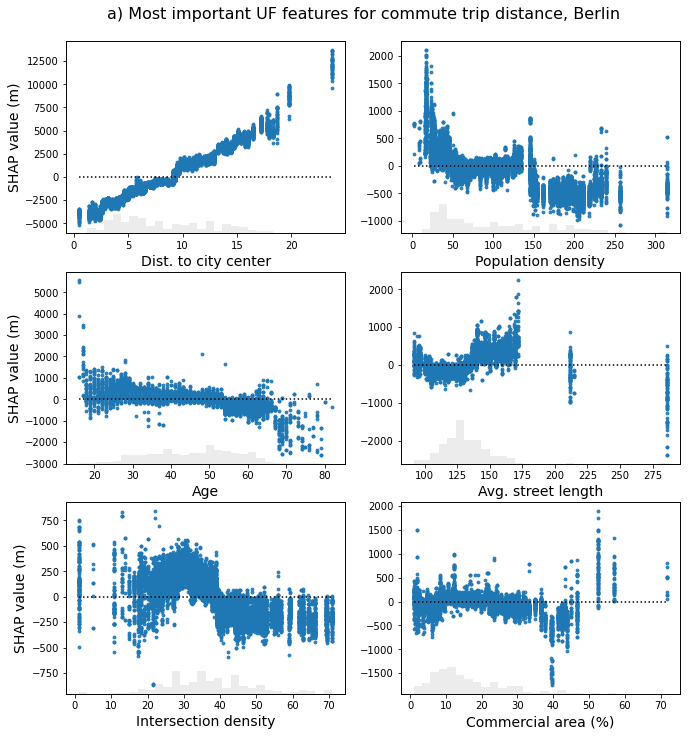

In [4]:
city='Berlin'

fp='../outputs/ML_Results/shap/dist_commute/' + city + '.pkl'
with open(fp, 'rb') as f:
    shap_values=pickle.load(f)

fp='../outputs/ML_Results/shap/dist_commute/' + city + '_importance.pkl'
with open(fp, 'rb') as f:
    importance_df=pickle.load(f)

fp='../outputs/ML_Results/shap/dist_commute/' + city + '_df.pkl'
with open(fp, 'rb') as f:
    df=pickle.load(f)
    
target='Trip_Distance'

n=importance_df.loc[importance_df['column_name'].isin(['DistCenter_res','DistSubcenter_res','UrbBuildDensity_res','IntersecDensity_res','UrbPopDensity_res','street_length_res','LU_Comm_res','LU_UrbFab_res','Age'])].index
X=df[[col for col in df.columns if "FeatureD" in col]]
X.sort_index(inplace=True)
data=X.sort_index().iloc[:,n]
data.columns=data.columns.str.replace("FeatureD_", "")
values=shap_values.sort_index().iloc[:,n]
#X_disp=[re.sub('FeatureD_','', x) for x in X.sort_index().columns]
col_dict= {'DistCenter_res':'Dist. to city center','DistSubcenter_res':'Dist. to subenter', 'UrbPopDensity_res':'Population density','UrbBuildDensity_res':'Built-up density',
    'IntersecDensity_res':'Intersection density','LU_Comm_res':'Commercial area (%)','LU_UrbFab_res':'Urban Fabric area (%)','street_length_res':'Avg. street length','bike_lane_share_res':'Cycle lanes (%)',
    'Trip_Time_Evening':'Evening trip','Trip_Time_AM_Rush':'Morning trip','Trip_Time_Nighttime Off-Peak':'Nighttime trip','Trip_Time_Lunch':'Lunchtime trip',
    'Season_Winter':'Winter season',
    'Age':'Age','Sex':'Sex','HHSize':'Household size',
    'Education_University':'University education', 'Occupation_Employed_FullTime':'Employed'}
data.rename(columns=col_dict,inplace=True)


if city == 'Berlin': let='a'
if city == 'Paris': let='b'
if city == 'Madrid': let='c'
if city == 'Wien': let='d'
if city == 'Germany_other': let='e'
if city == 'France_other': let='f'
if city == 'All': let='g'

xl=[]
yl=[]
y0=[]

for i in range(len(n)):
        dftemp=pd.DataFrame({'d':data.iloc[:,i],'v':values.iloc[:,i]})
        dftemp=dftemp.groupby('d')['v'].mean().reset_index()
        dftemp['v0']=0
        xl.append(dftemp['d'].values)
        yl.append(dftemp['v'].values)
        y0.append(dftemp['v0'].values)

fig = plt.figure(figsize=(11,12))
for i in range(0,6):
        ax1 = fig.add_subplot(321+i)
        xs=data.iloc[:,i]
        ys=values.iloc[:,i]
        x=xl[i]
        y1=y0[i]
        y2=yl[i]
        xlab=data.columns[i]

        #ax1.scatter(xs+np.random.normal(0, 0.05, len(data)),ys,alpha=0.9,s=8)
        ax1.scatter(xs,ys,alpha=0.9,s=8)
        plt.plot(x,y1,'k:',label='zero')
        if (xlab== 'Built-up density') & (city == 'Germany_other'):
                plt.xlim([0, 2e7])
        if i%2==0:
                ax1.set_ylabel('SHAP value (m)',size=14)
        else:
                ax1.set_ylabel('')
        ax1.set_xlabel(xlab,size=14)

        ax2 = ax1.twinx() 
        if len(xs.unique())==2:
                ax2.hist(xs,bins=[-0.5,0.5,1.5], align='mid',color='gray',alpha=0.25)
                ax2.set_xticks([-.5,0,0.5,1,1.5])
        else:
                ax2.hist(xs,bins=30,color='gray',alpha=0.15)
                ax2.set_ylim(0,len(data))
        ax2.set_yticks([])
plt.suptitle(let + ') ' +  "Most important UF features for commute trip distance, " + city.replace('_',', ').replace('Wien','Vienna'),y=0.92,size=16)
plt.savefig('../outputs/ML_Results/result_figures/dist_commute/' + city + '_mainUF.png',facecolor='w',dpi=65,bbox_inches='tight')